# MNIST Digit Recognition

In this notebook, we'll explore the classic problem of digit recognition using the MNIST dataset. The MNIST dataset consists of a large collection of handwritten digits (0-9) along with their corresponding labels. Our goal is to build a convolutional neural network (CNN) model that can accurately classify these digits.

## Imports

In [49]:
import random
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Model

Using convolutional neural networks (CNNs) is advantageous for the MNIST digit recognition problem due to their ability to automatically learn hierarchical features from images, making them well-suited for capturing local patterns and structures inherent in handwritten digits.

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=32 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)  # 10 classes for digits 0-9

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

Setting hyperparameters

In [5]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10

Load and preprocess the dataset. We use the MNIST dataset. 

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Initialize the model, loss function, and optimizer

In [7]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training loop

In [8]:
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 100 == 99:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

        # Store the average loss for this epoch
        losses.append(running_loss / len(train_loader))

print('Finished Training')

Epoch [1/10], Batch [100/938], Loss: 0.8465
Epoch [1/10], Batch [200/938], Loss: 0.2217
Epoch [1/10], Batch [300/938], Loss: 0.1685
Epoch [1/10], Batch [400/938], Loss: 0.1225
Epoch [1/10], Batch [500/938], Loss: 0.1021
Epoch [1/10], Batch [600/938], Loss: 0.0828
Epoch [1/10], Batch [700/938], Loss: 0.0851
Epoch [1/10], Batch [800/938], Loss: 0.0809
Epoch [1/10], Batch [900/938], Loss: 0.0731
Epoch [2/10], Batch [100/938], Loss: 0.0601
Epoch [2/10], Batch [200/938], Loss: 0.0587
Epoch [2/10], Batch [300/938], Loss: 0.0558
Epoch [2/10], Batch [400/938], Loss: 0.0543
Epoch [2/10], Batch [500/938], Loss: 0.0535
Epoch [2/10], Batch [600/938], Loss: 0.0560
Epoch [2/10], Batch [700/938], Loss: 0.0592
Epoch [2/10], Batch [800/938], Loss: 0.0500
Epoch [2/10], Batch [900/938], Loss: 0.0466
Epoch [3/10], Batch [100/938], Loss: 0.0381
Epoch [3/10], Batch [200/938], Loss: 0.0356
Epoch [3/10], Batch [300/938], Loss: 0.0358
Epoch [3/10], Batch [400/938], Loss: 0.0426
Epoch [3/10], Batch [500/938], L

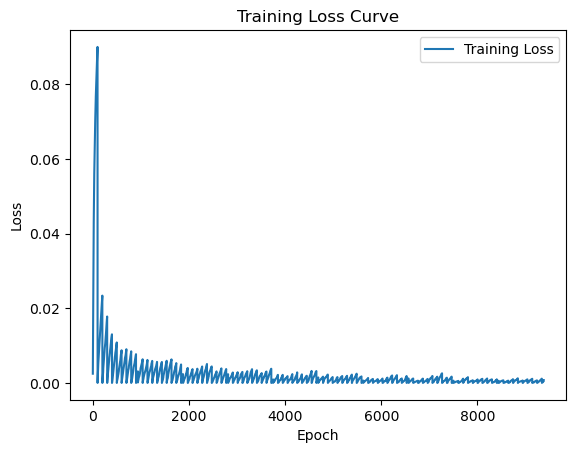

In [9]:
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

Save the trained model

In [10]:
torch.save(model.state_dict(), 'mnist_cnn_model.pth')

## Evaluation

Initialize the model, load the trained weights, and set the model to evaluation mode.

In [11]:
model = CNN()
model.load_state_dict(torch.load('mnist_cnn_model.pth'))
model.eval() 

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

This plot showcases the learned filters in the first convolutional layer of our CNN model. Filters represent image patterns detected by the model during training. These filters highlight edges, curves, and textures in the input images. By revealing these learned features, we gain insights into how the CNN interprets visual data, forming the foundation for higher-level feature extraction.

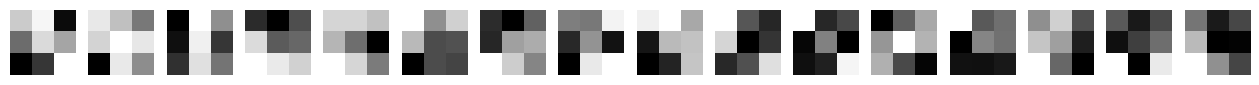

In [47]:
conv1_weights = model.conv1.weight.data
num_filters = conv1_weights.size(0)
plt.figure(figsize=(num_filters, 1))
for i in range(num_filters):
    plt.subplot(1, num_filters, i + 1)
    plt.imshow(conv1_weights[i].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.show()

Load and preprocess the test dataset.

In [50]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [45]:
correct, total = 0, 0
true_labels, predicted_labels = [], []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 98.95%


We choose five random images to visualize the prediction of our model. 

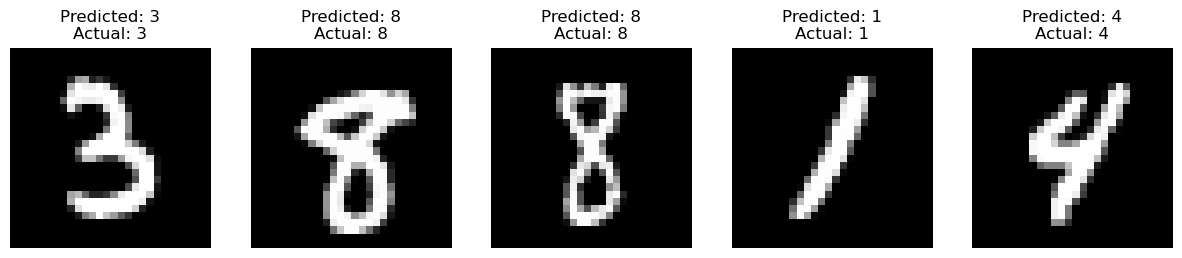

In [35]:
num_samples = 5
sample_indices = random.sample(range(len(test_dataset)), num_samples)

plt.figure(figsize=(15, 5))
for i, index in enumerate(sample_indices):
    image, label = test_dataset[index]
    output = model(image.unsqueeze(0))  # Unsqueeze to add batch dimension
    predicted_label = torch.argmax(output, dim=1).item()
    
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.title(f'Predicted: {predicted_label}\nActual: {label}')
    plt.axis('off')
plt.show()

### Confusion Matrix

The confusion matrix provides a comprehensive overview of a classification model's performance by revealing how many instances were correctly and incorrectly classified into each class, making it a valuable tool to assess the model's strengths and weaknesses.





In [36]:
def plot_confusion_matrix(cm, classes): 
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

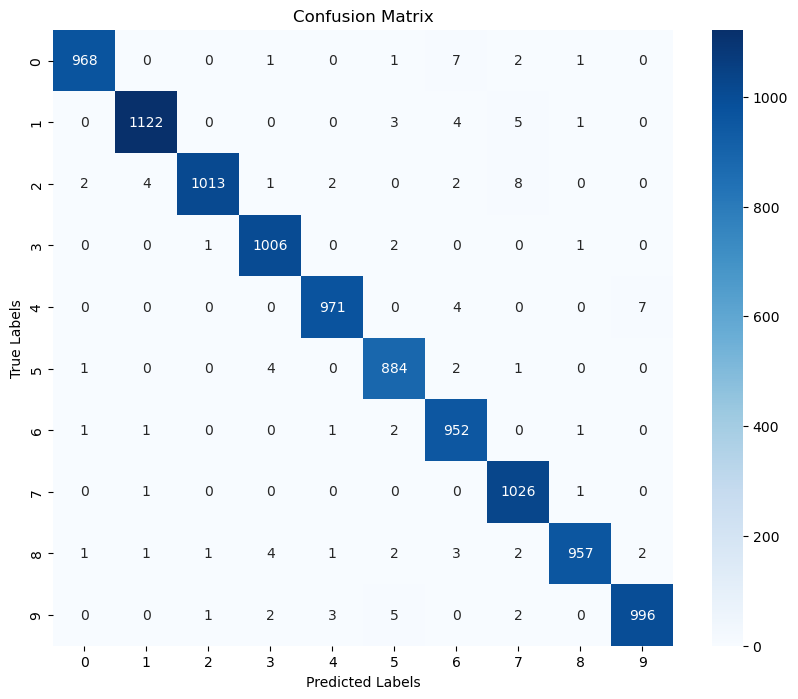

In [37]:
cm = confusion_matrix(true_labels, predicted_labels) 
classes = np.arange(10) 
plot_confusion_matrix(cm, classes) 

### Saliency Map

A saliency map highlights the most influential regions of an input image that contribute to a deep learning model's prediction, providing valuable insights into the model's decision-making process and aiding in the interpretation of its output.





Convert the image to a PyTorch variable

In [53]:
image_index = 0 
image, _ = test_dataset[image_index]
image_var = Variable(image.unsqueeze(0), requires_grad=True)

Calculate the model's prediction for the image


In [54]:
output = model(image_var)
predicted_class = torch.argmax(output).item()

Calculate gradients of the output with respect to the input image, extract the gradients and convert them to numpy, and calculate the absolute values of gradients to emphasize regions of influence

In [55]:
model.zero_grad()
output[0, predicted_class].backward()
gradients = image_var.grad[0].data.cpu().numpy()
saliency_map = np.abs(gradients).max(axis=0)

Normalize the saliency map for visualization

In [56]:
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

Plot the original image and its saliency map

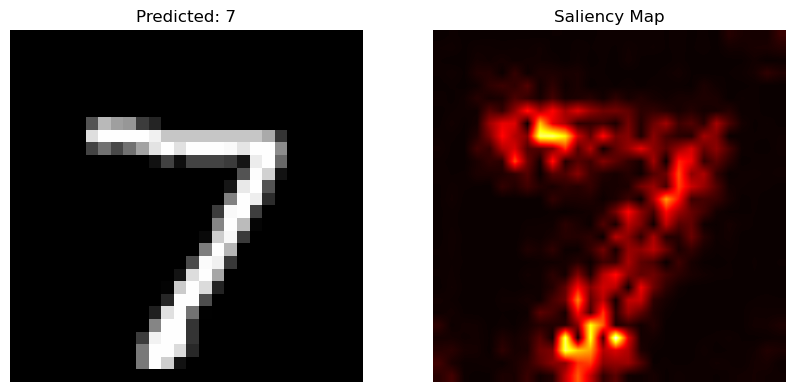

In [57]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[0], cmap='gray')
plt.title(f'Predicted: {predicted_class}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='hot', interpolation='bilinear')
plt.title('Saliency Map')
plt.axis('off')

plt.show()